In [1]:
%matplotlib inline
project_dir = '../../'
data_dir = project_dir + 'data/'

import sys
sys.path.append(project_dir + 'NN/')

import numpy as np
import importlib
import time
import matplotlib.pyplot as plt
import MLP
import layer
importlib.reload(MLP)
importlib.reload(layer)
from MLP import MLP, MLP_w
from utils.preprocessing import split,StandardScaler
from utils.results import plot_results, output_correlations
from utils.losses import MSE, MEE

In [2]:
''' FOR THE FIRST TIME
raw_data=np.loadtxt("../../data/TR.csv",delimiter=",")[:,1:]

sort_idx = np.argsort(raw_data[:,11]) ; raw_data = raw_data[sort_idx]
np.random.shuffle(raw_data)
input_data=raw_data[:,:-2]
input_labels=raw_data[:,-2:]

frac_test=0.15
data, test_set, labels, test_labels = split(input_data, input_labels, 
                                            kind="hold_out",frac_training=1-frac_test)
Test_dataset = np.column_stack((test_set,test_labels))
Data_dataset = np.column_stack((data,labels))
np.savetxt('../../data/Test_set.txt',Test_dataset) ; np.savetxt('../../data/Data_set.txt',Data_dataset)
'''
raw_data = np.loadtxt("../../data/Data_set.txt")
data_scaler = StandardScaler() 
labels_scaler = StandardScaler(kind = 'vector')

raw_data[:,:-2] = data_scaler.fit_transform(raw_data[:,:-2]) 
raw_data[:,-2:] = labels_scaler.fit_transform(raw_data[:,-2:])

#splitting the data from the labels
data=raw_data[:,:-2]
labels=raw_data[:,-2:]

In [3]:
#xavier weight inizialization
def xavier(structure):
    start=np.zeros(len(structure))
    for idx,num in enumerate(structure):
        if idx==0:
            start[idx]=np.sqrt(6)/np.sqrt(structure[idx])
        else:
            start[idx]=np.sqrt(6)/np.sqrt(structure[idx-1]+structure[idx])
    return list(start)

In [4]:
list_lamb = np.logspace(-7,-5,5)  ; print(list_lamb)

[1.00000000e-07 3.16227766e-07 1.00000000e-06 3.16227766e-06
 1.00000000e-05]


In [6]:
import utils.grid_search
importlib.reload(utils.grid_search)
from utils.grid_search import grid_search

# Structure to test: 
n_feat = np.shape(labels)[1]
model1 = {'structure':[20, n_feat], 'func':["relu", 'linear'], 'starting_points': xavier([20, n_feat])}
model2 = {'structure':[5,5,n_feat], 'func':['relu','relu','linear'], 'starting_points': xavier([5,5, n_feat])}
model3 = {'structure':[10,10,n_feat], 'func':['relu','relu','linear'],'starting_points': xavier([10,10,n_feat])}

models = [model1, model2, model3]#, 
dict_models = {f'Model{i}': m for i, m in enumerate(models)} 

list_eta = [1e-4]
list_alpha = np.arange(0.1,0.3,0.1)
list_lamb = np.logspace(-7,-5, 3) ; list_beta = np.arange(0.75, 0.85, 0.05)
dict_params = {'eta':list_eta, 'alpha':list_alpha, 'lamb':list_lamb, 'epoch':[10000], 
               'RMSProp' : [True], 'nesterov' : [True], 'beta' : list_beta ,
               'verbose' : [False], 'batch_size' : [-1, 32], 'error_threshold' : [0] ,
               'patience' : [300], 'n_candidate':[3], 'test_more_init':[True]}

grid_results = grid_search(MLP_w, dict_models, dict_params, 
                           data, labels, MEE, n_jobs = 8,
                           verbose = 1, kind = 'k_fold', k = 4)

start training 72 possible combinations
[trained=24] [elaps t=4.6 s] [remain t =9.2 s]


KeyboardInterrupt: 

In [11]:
grid_results[0]
#np.savetxt('../../data/sigmoid_search.txt',grid_results[1:10])

{'train': {'eta': 8e-05,
  'alpha': 0.2,
  'lamb': 4.641588833612782e-06,
  'epoch': 10000,
  'RMSProp': True,
  'nesterov': True,
  'beta': 0.7,
  'verbose': False,
  'batch_size': 32,
  'error_threshold': 0,
  'patience': 200},
 'model': {'structure': [10, 10, 2],
  'func': ['tanh', 'tanh', 'linear'],
  'starting_points': [0.7745966692414833,
   0.5477225575051661,
   0.7071067811865475]},
 'model_name': 'Model2',
 'Error': 0.276885430060327}

In [12]:
#Comment after the grid search is ended
import json

with open('../report/tanh.json','w') as fp:
    json.dump(grid_results,fp) 


In [56]:
raw_data = np.loadtxt("../../data/Data_set.txt")

data_scaler = StandardScaler()
labels_scaler = StandardScaler()

raw_data[:,:-2] = data_scaler.fit_transform(raw_data[:,:-2]) 
raw_data[:,-2:] = labels_scaler.fit_transform(raw_data[:,-2:])

#splitting the data from the labels
data=raw_data[:,:-2]
labels=raw_data[:,-2:]

frac_training=0.8
input_data, val_data, train_labels, val_labels=split(data, labels,kind="hold_out",
                                                     frac_training=frac_training)

mypath = '../report/json/'
file = mypath + 'all_dict.json'

with open(file) as json_file:
    f_dict = json.load(json_file)

frac_training=0.8
input_data, val_data, train_labels, val_labels=split(data, labels,kind="hold_out",
                                                     frac_training=frac_training)
best_model_dict = f_dict[5]
best_model_dict['model']
best_model = MLP_w(**best_model_dict['model'])
train_dict = dict(best_model_dict['train'])
train_dict['verbose'] = True
train_dict['patience'] = 100

best_model.train(input_data, train_labels, val_data, val_labels, 
                 n_candidate=5, test_more_init=True, **train_dict)

Candidate 0
Epoch 2996:  [train MEE = 0.2570]  [val MEE = 0.2778]                              
Elapsed time: 6.8890156745910645 s
Candidate 1
Epoch 5167:  [train MEE = 0.2520]  [val MEE = 0.2707]                              
Elapsed time: 12.067673444747925 s
Candidate 2
Epoch 4883:  [train MEE = 0.2458]  [val MEE = 0.2721]                              
Elapsed time: 12.06449556350708 s
Candidate 3
Epoch 5502:  [train MEE = 0.2435]  [val MEE = 0.2800]                              
Elapsed time: 14.729102373123169 s
Candidate 4
Epoch 3643:  [train MEE = 0.2604]  [val MEE = 0.2862]                              
Elapsed time: 9.143936157226562 s


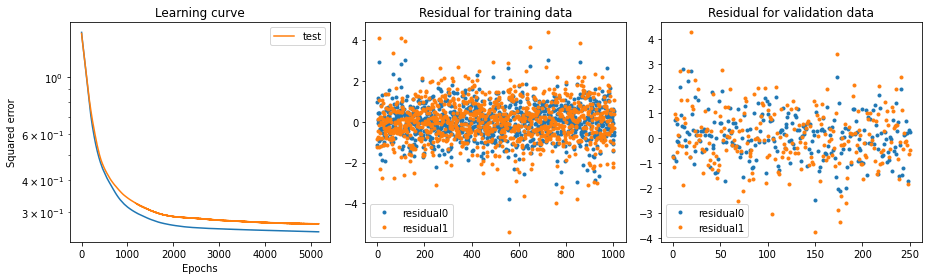

final train error: 1.0647172750127474
final val error: 1.158428945147364


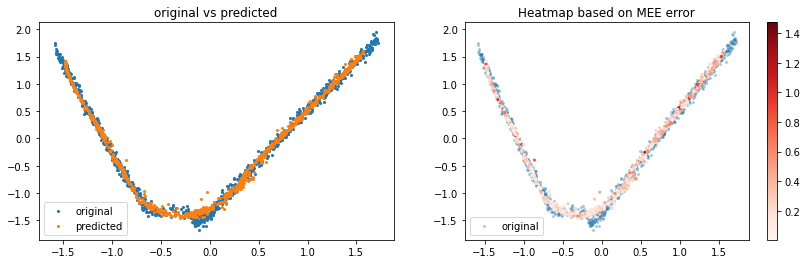

In [58]:
plot_results(best_model, input_data, val_data, train_labels, val_labels, 
             norm = labels_scaler.inverse_transform)
output_correlations(best_model, input_data, train_labels)